# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 208705277 209545441 ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

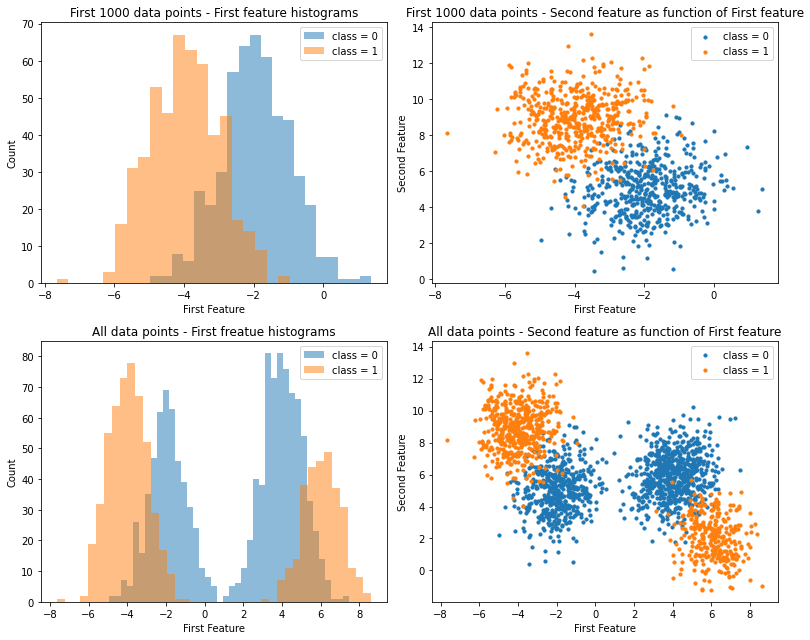

In [4]:
x = X_training
y = y_training

fig, axs = plt.subplots(2, 2)
### First Graph
class_0 = x[np.where(y[:1000] == 0)][:,0]
class_1 = x[np.where(y[:1000] == 1)][:,0]
axs[0,0].hist(class_0, bins=20, alpha=0.5, label="class = 0")
axs[0,0].hist(class_1, bins=20, alpha=0.5, label="class = 1")
axs[0,0].set_title("First 1000 data points - First feature histograms")
axs[0,0].set_xlabel("First Feature")
axs[0,0].set_ylabel("Count")
axs[0,0].legend()

### Second Graph
class_0 = x[np.where(y == 0)][:,0]
class_1 = x[np.where(y == 1)][:,0]
axs[1,0].hist(class_0, bins=40, alpha=0.5, label="class = 0")
axs[1,0].hist(class_1, bins=40, alpha=0.5, label="class = 1")
axs[1,0].set_title("All data points - First freatue histograms")
axs[1,0].set_xlabel("First Feature")
axs[1,0].set_ylabel("Count")
axs[1,0].legend()

### Third Graph
class_0 = x[np.where(y[:1000] == 0)]
class_1 = x[np.where(y[:1000] == 1)]
axs[0,1].scatter(class_0[:,0], class_0[:,1], s=10, label="class = 0")
axs[0,1].scatter(class_1[:,0], class_1[:,1], s=10, label="class = 1")
axs[0,1].set_title("First 1000 data points - Second feature as function of First feature")
axs[0,1].set_xlabel("First Feature")
axs[0,1].set_ylabel("Second Feature")
axs[0,1].legend()

# Fourth Graph
class_0 = x[np.where(y == 0)]
class_1 = x[np.where(y == 1)]
axs[1,1].scatter(class_0[:,0], class_0[:,1], s=10, label="class = 0")
axs[1,1].scatter(class_1[:,0], class_1[:,1], s=10, label="class = 1")
axs[1,1].set_title("All data points - Second feature as function of First feature")
axs[1,1].set_xlabel("First Feature")
axs[1,1].set_ylabel("Second Feature")
axs[1,1].legend()

fig.set_size_inches(11, 9)
fig.tight_layout()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [5]:
def hypothesis(x, theta):
    power = np.dot(x, np.transpose(theta))
    return 1 / (1 + np.exp(-power))

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.current_theta = None
        self.cost_history = list()

        
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        i = 0
        X = np.column_stack((np.ones(np.shape(X)[0]), X))
        np.random.seed(self.random_state)
        theta = np.random.rand(1, X.shape[1])
        m = X.shape[0]
        diff = np.Inf
        while (i < self.n_iter and diff > self.eps):
            h = hypothesis(X, theta)
            cost = (-1 / m) * (np.sum(np.dot(y , np.log(h)) + np.dot((1 - y), np.log(1- h))))
            self.cost_history.append(cost)
            if i > 1:
                diff = np.abs(self.cost_history[-2] - self.cost_history[-1])
            gradient = np.dot(h[:,0] - y, X)
            theta -= self.eta * gradient
            self.current_theta = theta
            i += 1
        

    def predict(self, X):
        """Return the predicted class label"""
        predictions = list()
        for x in X:
            h = hypothesis(np.append(1, x), self.current_theta)
            if (h > 0.5):
                predictions.append(1)
            else:
                predictions.append(0)
        return np.asarray(predictions)

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
#### Your code here ####
### With 5-fold cross validation ###
np.random.seed(1)
shuffled_training_set = np.copy(training_set[['x1', 'x2' ,'y']].values)
np.random.shuffle(shuffled_training_set)
X_shuffled_training = shuffled_training_set[:, [0,1]]
y_shuffled_training = shuffled_training_set[:,2]
splitted_X = np.array_split(X_shuffled_training, 5)
splitted_y = np.array_split(y_shuffled_training, 5)
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
best_pair = None
max_acc = 0
for i, eta in enumerate(etas):
    current_valid_X = splitted_X[i]
    current_valid_y = splitted_y[i]
    valid_size = current_valid_X.shape[0]
    train_size = X_shuffled_training.shape[0] - valid_size
    current_train_X = np.array([x for j, x in enumerate(splitted_X) if j != i])
    current_train_X = current_train_X.reshape(train_size, X_shuffled_training.shape[1])
    current_train_y = np.array([y for j, y in enumerate(splitted_y) if j != i])
    current_train_y = current_train_y.reshape(train_size, )
    for eps in epss:
        logreg = LogisticRegressionGD(eta = eta, eps = eps)
        logreg.fit(current_train_X, current_train_y)
        acc = 0
        for j in range(valid_size):
            pred = logreg.predict(current_valid_X)
            if (pred[j] == current_valid_y[j]):
                acc += 1
        acc /= valid_size
        if acc > max_acc:
            max_acc = acc
            best_pair = (eta, eps)
    
print(f"The best eta, eps pair is: {best_pair}. Giving accuracy of {max_acc}.")

The best eta, eps pair is: (5e-05, 1e-06). Giving accuracy of 0.7825.


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [8]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    ans = np.power(2 * np.pi * np.square(sigma), -0.5)
    exponent = (-0.5 * np.square(data - mu)) / np.square(sigma)
    ans *= np.exp(exponent)
    return ans

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.params = dict()
        self.responsibilities = np.array([])
        self.cost_history = list()

        
    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        dataSplit = np.array_split(data, self.k)       
        for j in range(self.k):
            w_j = (1 / self.k)
            mu_j = np.mean(dataSplit[j])
            sigma_j = np.std(dataSplit[j])
            self.params[j] = (w_j, mu_j, sigma_j)
            
            
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        self.responsibilities = np.array([])
        for i in range(data.shape[0]):
            x = data[i]
            r_arr = np.array([])
            for j in range(self.k):
                w_j = self.params.get(j)[0]
                mu_j = self.params.get(j)[1]
                sigma_j = self.params.get(j)[2]
                r_arr = np.append(r_arr, w_j * norm_pdf(x, mu_j ,sigma_j))
            r_arr /= np.sum(r_arr)
            self.responsibilities = np.append(self.responsibilities, r_arr)
        self.responsibilities = self.responsibilities.reshape(data.shape[0], self.k)
        
        
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        N = data.shape[0]
        for j in range(self.k):
            r_arr = self.responsibilities[:,j]
            w_j = np.sum(r_arr) / N
            mu_j = np.sum(r_arr * data) / (w_j * N)
            sigma_j = np.power(np.sum(r_arr * np.square(data - mu_j)) / (w_j * N), 0.5)
            self.params[j] = (w_j, mu_j, sigma_j)
   
    def calc_cost(self, data):
        cost_vec = np.array([])
        for j in range(self.k):
            cost_vec = np.append(cost_vec, np.sum(-1 * np.log(self.params.get(j)[0] *
                                                      norm_pdf(data, self.params.get(j)[1], self.params.get(j)[2]))))
        return np.sum(cost_vec)
    
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        i = 0
        diff = np.Inf
        while (i < self.n_iter and diff > self.eps):
            self.expectation(data)
            self.maximization(data)
            cost = self.calc_cost(data)
            self.cost_history.append(cost)
            if i > 1:
                diff = np.abs(self.cost_history[-2] - self.cost_history[-1])
            i += 1
            
            
    def get_dist_params(self):
        return self.params

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [10]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.priors = list()
        self.params = list()
        self.params.append(list())
        self.params.append(list())

        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.priors.append(np.count_nonzero(y == 0) / y.shape[0])
        self.priors.append(1 - self.priors[0])
        em = EM(k=self.k)
        for cls in range(2):
            for i in range(X.shape[1]):
                curr_X = np.copy(X[np.where(y == cls)][:,i])
                em.fit(curr_X)
                curr_params = em.get_dist_params().copy()
                self.params[cls].append(curr_params)
      
    
    def likelihood(self, x, cls):
        """Calculate the likelihood from the em gmm"""
        likelihood = 1
        for i in range(x.shape[0]):
            prob = 0
            for j in range(self.k):
                curr_params = self.params[cls][i].get(j)
                prob += (curr_params[0] * norm_pdf(x[i], curr_params[1], curr_params[2]))
            likelihood *= prob
        return likelihood
        

    def predict(self, X):
        """Return the predicted class label"""
        predictions = list()
        for i in range(X.shape[0]):
            x = X[i]
            posterior_0 = self.priors[0] * self.likelihood(x, 0)
            posterior_1 = self.priors[1] * self.likelihood(x, 1)
            if posterior_0 > posterior_1:
                predictions.append(0)
            else:
                predictions.append(1)
        return np.asarray(predictions)

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [11]:
def calc_accuracy(predictor, X, y):
    accuracy = 0
    predictions = predictor.predict(X)
    for i in range(X.shape[0]):
        if (predictions[i] == y[i]):
            accuracy +=1
    accuracy /= y.size
    
    return accuracy

In [12]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

First Part
Logistic Regression train accuracy is: 0.965
Logistic Regression test accuracy is: 0.938
Naive Bayes using GMM train accuracy is: 0.966
Naive Bayes using GMM test accuracy is: 0.942


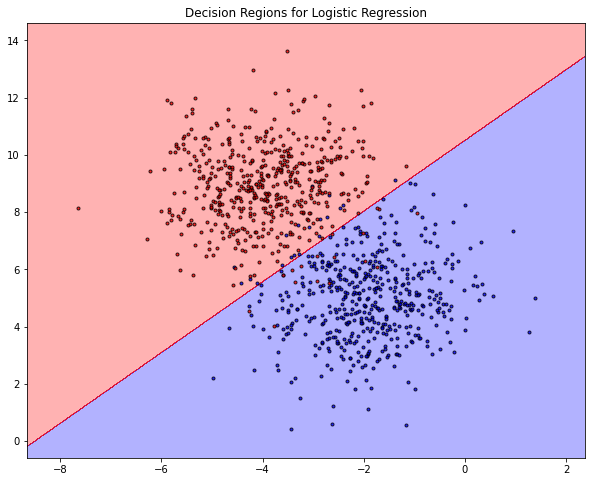

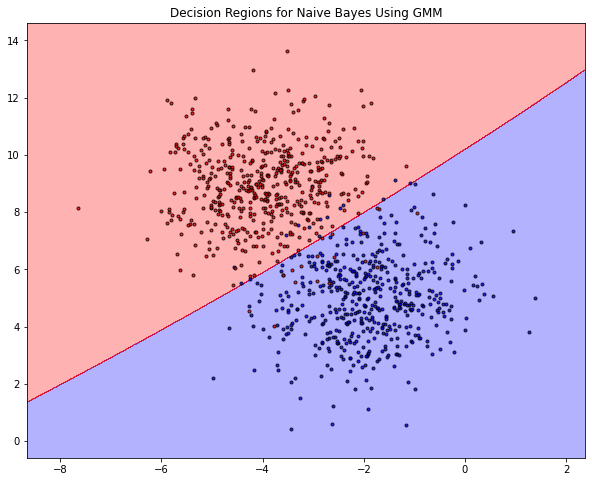

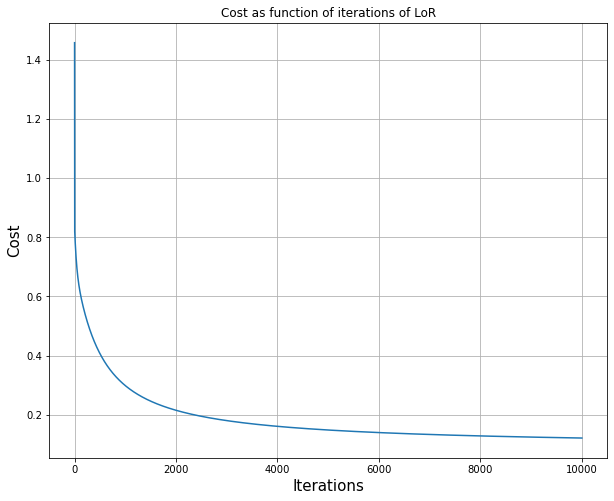

Second Part
Logistic Regression train accuracy is: 0.809
Logistic Regression test accuracy is: 0.804
Naive Bayes using GMM train accuracy is: 0.9215
Naive Bayes using GMM test accuracy is: 0.902


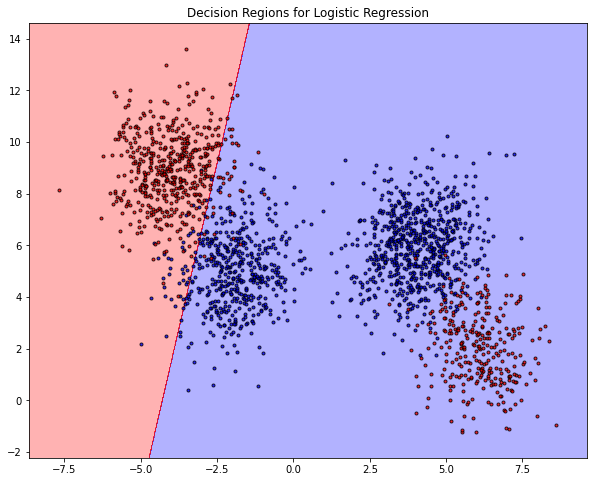

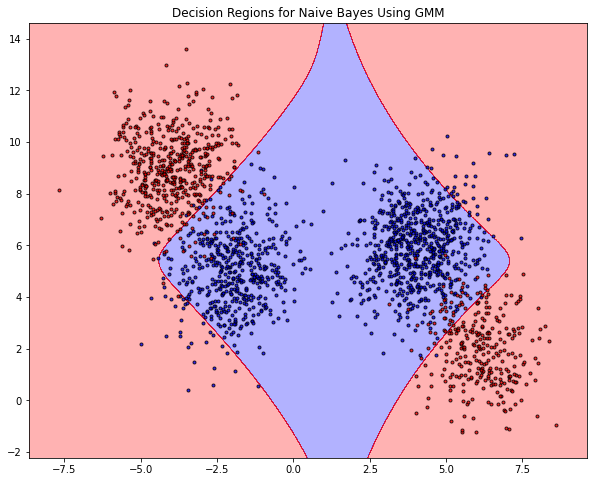

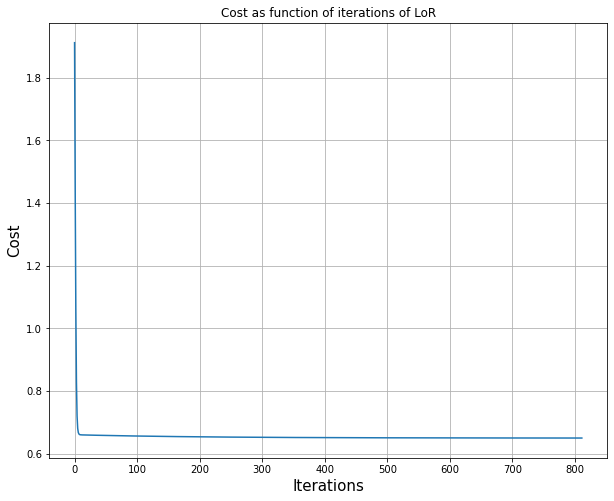

In [13]:
#### Your code here ####
def Train_and_Plot(X, y, X_t, y_t, k):
    (best_eta, best_eps) = best_pair
    LoR = LogisticRegressionGD(eta = best_eta, eps = best_eps)
    LoR.fit(X, y)
    NBG = NaiveBayesGaussian(k=k)
    NBG.fit(X, y)
    LoR_train_acc = calc_accuracy(LoR, X, y)
    LoR_test_acc = calc_accuracy(LoR, X_t, y_t)

    NBG_train_acc = calc_accuracy(NBG, X, y)
    NBG_test_acc = calc_accuracy(NBG, X_t, y_t)

    print(f"Logistic Regression train accuracy is: {LoR_train_acc}")
    print(f"Logistic Regression test accuracy is: {LoR_test_acc}")

    print(f"Naive Bayes using GMM train accuracy is: {NBG_train_acc}")
    print(f"Naive Bayes using GMM test accuracy is: {NBG_test_acc}")
    
    plt.figure()
    plot_decision_regions(X, y, LoR)
    plt.title("Decision Regions for Logistic Regression")
    plt.figure()
    plt.title("Decision Regions for Naive Bayes Using GMM")
    plot_decision_regions(X, y, NBG)

    plt.figure()
    costs = LoR.cost_history
    plt.plot(range(len(costs)), costs)
    plt.xlabel("Iterations", fontsize=15)
    plt.ylabel("Cost", fontsize=15)
    plt.title("Cost as function of iterations of LoR")
    plt.grid()
    plt.show()
    
### First Part ###
print("First Part")
X = X_training[:1000]
y = y_training[:1000]
X_t = X_test[:500]
y_t = y_test[:500]
Train_and_Plot(X, y, X_t, y_t, 1)

### Second Part ###
print("Second Part")
Train_and_Plot(X_training, y_training, X_test, y_test, 2)

**Explanation for each Graph**

*First Part*

For the first part, the decision region graphs are similar since the data is both lineraly seperable and the features are independent. Which allows both algorithms to seperate the data well. The cost algorithm is pretty much self-explanatory, it plots the cost history of the EM Naive Bayes.

*Second Part*

For the second part, the Decision Regions for Logistic Regression does no seperates the data well as it is not linearly seperable. The Desicion Regions for Naive Bayes using EM does a good job seperating the data again since the features are independant. The cost algorithm is pretty much self-explanatory, it plots the cost history of the EM Naive Bayes.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


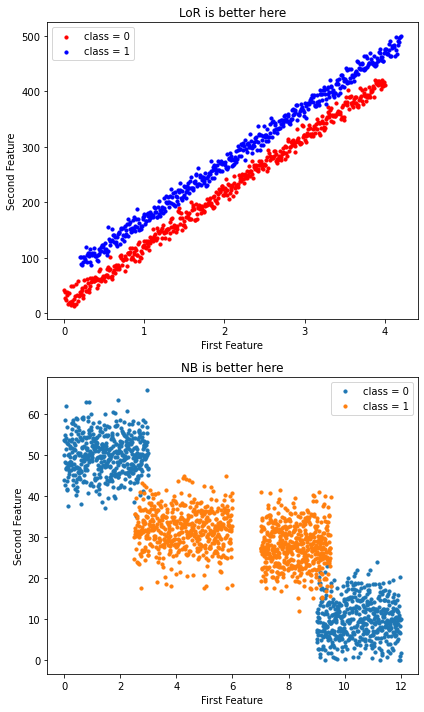

In [14]:
import random
fig, axs = plt.subplots(2, 1)

### LoR will work better
def y(x, m, b):
     return m*x + b
    
m, b = 1, 0

x1 = np.linspace(0, 4, 500)
x2 = np.linspace(0.2, 4.2, 500)

y1 = [y(x, 100, 0) + abs(random.gauss(20,10)) for x in x1]
y2 = [y(x, 100, 50) + abs(random.gauss(20,10)) for x in x2]

axs[0].scatter(x1,y1, s=10, label="class = 0",color='r')
axs[0].scatter(x2,y2, s=10, label="class = 1",color='b')

axs[0].set_title("LoR is better here")
axs[0].set_xlabel("First Feature")
axs[0].set_ylabel("Second Feature")
axs[0].legend()

# NB using EM will work better
x11 = np.linspace(0, 3, 500)
x12 = np.linspace(9, 12, 500)
x1 = np.append(x11,x12)
x21 = np.linspace(2.5, 6, 500)
x22 = np.linspace(7, 9.5, 500)
x2 = np.append(x21,x22)

x = np.append(x1,x2)
y1 = np.append([abs(random.gauss(50,5)) for x in x11],[abs(random.gauss(10,5)) for x in x12])
y2 = np.append([abs(random.gauss(32,5)) for x in x21],[abs(random.gauss(28,5)) for x in x22])

axs[1].scatter(x1,y1, s=10, label="class = 0")
axs[1].scatter(x2,y2, s=10, label="class = 1")
axs[1].set_title("NB is better here")
axs[1].set_xlabel("First Feature")
axs[1].set_ylabel("Second Feature")
axs[1].legend()

fig.set_size_inches(6, 10)
fig.tight_layout()

**Explanation**

In the first graph we see a data which is clearly linearly separatable, thus the logistic regression will perform great. On the other hand, NB will work worse than the LoR for the following reasons:
Given the class the features are highly dependent and thus the NB assumption doesn't hold. Secondly, the marginal distribution for each feature is the same almost which interrupts the NB work too.

In the second graph we see a data where NB assumption holds, thus it will work, but it is clearly not linearly separatable – LoR will work poorly.
